In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')

In [3]:
import json
import os
from collections import OrderedDict, defaultdict, Counter
from copy import deepcopy
from random import sample

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from data_management.cct_json_utils import CameraTrapJsonUtils, IndexedJsonDb
from visualization.visualization_utils import plot_stacked_bar_chart

## Species distribution

In [47]:
def get_images_annotations(file_template):
    # combine train and val splits for the image databases
    all_images = []
    all_annotations = []

    for i in ('train', 'val'):
        with open(file_template.format(i)) as f:
            db = json.load(f)
        print('{} has {} images, {} annotations'.format(i, len(db['images']), len(db['annotations'])))
        all_images.extend(db['images'])
        all_annotations.extend(db['annotations'])
    
    print('In total there are {} images, {} annotations'.format(len(all_images), len(all_annotations)))
    return all_images, all_annotations, db


def show_species_dist(file_template, plot_title='', ordered_species_list=None, log_scale=False):
    all_images, all_annotations, db = get_images_annotations(file_template)
    
    db_indexed = IndexedJsonDb(db)  # assume both train and val have the same categories field

    # get species by location
    
    image_to_loc = {}
    loc_to_species = defaultdict(Counter)

    for i in all_images:
        image_to_loc[i['id']] = i['location']

    for a in all_annotations:
        cat_name = db_indexed.cat_id_to_name[a['category_id']]
        loc = image_to_loc[a['image_id']]
        loc_to_species[loc].update([cat_name])
    
    all_species = set()
    for v in loc_to_species.values():
        for k in v.keys():
            all_species.add(k)
    
    loc_to_species_sorted = sorted(loc_to_species.items(), key=lambda x: sum(x[1].values()), reverse=True)

#     print('')
#     for index, item in enumerate(loc_to_species_sorted):
#         print(index, item)  # the same content as the plot
        
    series_labels = ordered_species_list
    #series_labels.reverse()  # uncomment this line for CCT-20
    
    col_labels = [x[0] for x in loc_to_species_sorted] # locations are the key in loc_to_species_sorted
    
    species_data = []
    for s in series_labels:
#         if s == 'empty' or s == 'gazellethomsons' or s == 'zebra' or s == 'gazellegrants' or s == 'human' or s == 'guineafowl':
#             continue
        s_across_locs = []
        for loc, counter in loc_to_species_sorted:
            s_across_locs.append(counter[s])
        species_data.append(s_across_locs)
    
    fig = plot_stacked_bar_chart(species_data, series_labels, col_labels=col_labels, 
                             x_label='Location ID', 
                             y_label='Number of images', log_scale=log_scale)

    fig.suptitle(plot_title)
    
    return fig

In [17]:
# get the most populous species
def get_most_populous_species(file_template):

    all_annotations = []

    for i in ('train', 'val'):
        with open(file_template.format(i)) as f:
            db = json.load(f)
        print('{} has {} images, {} annotations'.format(i, len(db['images']), len(db['annotations'])))
        all_annotations.extend(db['annotations'])

    db_indexed = IndexedJsonDb(db) # assume same categories in train and val

    species_counter = Counter()
    for a in all_annotations:
        cat_name = db_indexed.cat_id_to_name[a['category_id']]
        species_counter.update([cat_name])

    species_counter_sorted = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
    return species_counter_sorted

### Species distribution - CCT

Uncomment the .reverse() line in the function above so that "empty" is in red.

In [59]:
file_template = '/beaver_disk/camtrap/caltech/benchmark/caltech_images_20190919_{}.json'
ordered_species = ['empty', 'car']  # if you want to control the first few species
plot_title = 'CCT (top 20 categories)'

species_counter_sorted = get_most_populous_species(file_template)
ordered = [i[0] for i in species_counter_sorted]
ordered = ordered[:20] # to be the same as on https://beerys.github.io/CaltechCameraTraps/
ordered.reverse() 

train has 180690 images, 181844 annotations
val has 62410 images, 63274 annotations


train has 180690 images, 181844 annotations
val has 62410 images, 63274 annotations
In total there are 243100 images, 245118 annotations


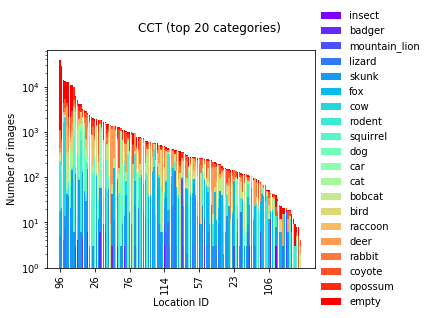

In [60]:
fig = show_species_dist(file_template, plot_title=plot_title, ordered_species_list=ordered, log_scale=True)

In [61]:
fig.savefig('/home/marmot/camtrap/mnt/intermediate/dataset_paper/species_dist_cct_all.svg', 
            format='svg', bbox_inches='tight')

train has 32865 images, 32873 annotations
val has 25000 images, 25070 annotations
In total there are 57865 images, 57943 annotations

There are 17 species:
{'unlabeled_animal', 'car', 'fox', 'deer', 'opossum', 'bobcat', 'raccoon', 'dog', 'skunk', 'cat', 'squirrel', 'empty', 'coyote', 'rodent', 'badger', 'rabbit', 'bird'}

ordered_species_list of 17 items:
['squirrel', 'skunk', 'rodent', 'raccoon', 'rabbit', 'opossum', 'fox', 'dog', 'deer', 'coyote', 'cat', 'bobcat', 'bird', 'badger', 'car', 'unlabeled_animal', 'empty']


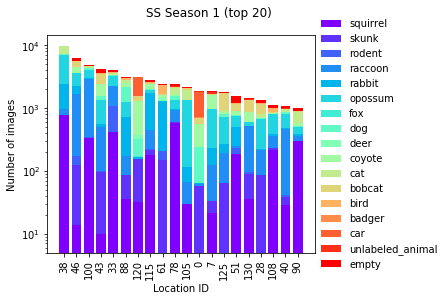

In [39]:
cct_log_fig = show_species_dist(file_template, plot_title=plot_title, ordered_species_list=ordered_species,
                               log_scale=True)

### Species distribution - SS season 1

49 species is too many to show. Show top 20 instead

In [65]:
ss_file_template = '/beaver_disk/camtrap/ss_season1/benchmark/ss_season1_images_20190919_{}.json'

In [66]:
species_counter_sorted = get_most_populous_species(ss_file_template)

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations


In [71]:
ordered = [i[0] for i in species_counter_sorted]
ordered = ordered[:20] # to be the same as on https://beerys.github.io/CaltechCameraTraps/
ordered.reverse() 

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations
In total there are 411414 images, 412858 annotations


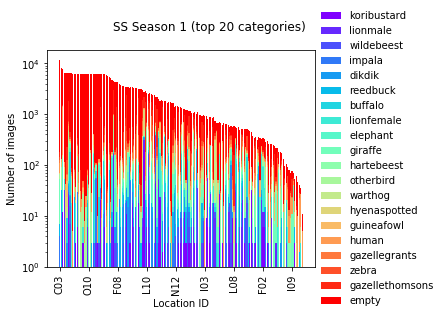

In [73]:
plot_title = 'SS Season 1 (top 20 categories)'

fig = show_species_dist(ss_file_template, plot_title=plot_title, ordered_species_list=ordered, log_scale=True)

In [74]:
fig.savefig('/home/marmot/camtrap/mnt/intermediate/dataset_paper/species_dist_ss_log.svg', 
            format='svg', bbox_inches='tight')

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations
In total there are 411414 images, 412858 annotations

There are 49 species:
{'waterbuck', 'baboon', 'otherbird', 'wildcat', 'zebra', 'warthog', 'human', 'jackal', 'giraffe', 'hyenaspotted', 'empty', 'gazellethomsons', 'leopard', 'rodents', 'cheetah', 'aardwolf', 'caracal', 'serval', 'bushbuck', 'hartebeest', 'lionmale', 'hare', 'monkeyvervet', 'lionfemale', 'ostrich', 'genet', 'topi', 'elephant', 'secretarybird', 'porcupine', 'impala', 'aardvark', 'batearedfox', 'koribustard', 'civet', 'reptiles', 'reedbuck', 'rhinoceros', 'guineafowl', 'dikdik', 'mongoose', 'hyenastriped', 'buffalo', 'honeybadger', 'hippopotamus', 'wildebeest', 'gazellegrants', 'eland', 'zorilla'}

ordered_species_list of 20 items:
['koribustard', 'lionmale', 'wildebeest', 'impala', 'dikdik', 'reedbuck', 'buffalo', 'lionfemale', 'elephant', 'giraffe', 'hartebeest', 'otherbird', 'warthog', 'hyenaspotted', 'guineafowl', 'human', 'gazelle

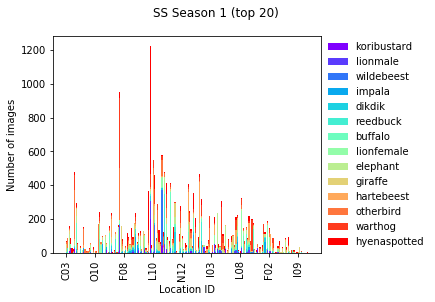

In [36]:
# excluding the top few animals
# the leveling around 10 is because many species have very few instances
fig2 = show_species_dist(ss_file_template, plot_title=plot_title, ordered_species_list=top_20, log_scale=False)

## Multiple species per image

In [6]:
cct_images, cct_annotations = get_images_annotations('/beaver_disk/camtrap/caltech/benchmark/cct-20/CaltechCameraTraps-20_v2.1_{}.json')

train has 32865 images, 32873 annotations
val has 25000 images, 25070 annotations
In total there are 57865 images, 57943 annotations


In [7]:
ss1_images, ss1_annotations = get_images_annotations('/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiS01_{}.json')

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations
In total there are 411414 images, 412858 annotations


In [9]:
def num_images_multi_label(annotations):
    image_id_to_num_labels = defaultdict(int)
    
    for a in annotations:
        if 'category_id' in a:
            image_id_to_num_labels[a['image_id']] += 1
    
    counter = defaultdict(int)
    for i, num in image_id_to_num_labels.items():
        counter[num] += 1
    print(counter)

In [10]:
num_images_multi_label(cct_annotations)

defaultdict(<class 'int'>, {1: 57787, 2: 78})


In [11]:
num_images_multi_label(ss1_annotations)

defaultdict(<class 'int'>, {1: 409988, 2: 1408, 3: 18})


In [12]:
(1408 + 18) / 411414

0.0034660949797527553